In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
#from qiskit.test.mock import FakeAlmaden
#backend = FakeAlmaden()
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [6]:
theta = np.pi / 2
phi = theta * 0.8752795188418716 / 1.8095454182113748
num_trotter_steps = 6

In [7]:
schedules = []

In [8]:
HH = cmd_def.get('u2', qubits=[0], P0=0, P1=np.pi) | cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi)

RZRZ = cmd_def.get('u1', qubits=[0], P0=theta) | cmd_def.get('u1', qubits=[1], P0=phi)

CNOT_RZ_CNOT = cmd_def.get('cx', qubits=[0, 1])
CNOT_RZ_CNOT |= cmd_def.get('u1', qubits=[1], P0=theta) << CNOT_RZ_CNOT.duration
CNOT_RZ_CNOT |= cmd_def.get('cx', qubits=[0, 1]) << CNOT_RZ_CNOT.duration

schedule = HH
for _ in range(num_trotter_steps):
    schedule |= RZRZ << schedule.duration
    schedule |= CNOT_RZ_CNOT << schedule.duration
schedule |= HH << schedule.duration
schedule |= measure << schedule.duration

schedules.append(schedule)

In [9]:
## Optimized Way:
circuit = q.QuantumCircuit(2)
circuit.h(0); circuit.h(1);
for _ in range(num_trotter_steps):
    circuit.rz(theta, 0); circuit.rz(phi, 1);
    circuit.zz_interaction(theta, 0, 1)
circuit.h(0); circuit.h(1);

decomposed_circuit = circuit.decompose()

pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
schedule |= measure << schedule.duration
schedules.append(schedule)

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/providers/models/backendconfiguration.py:399: UserWarning: The control channel appropriate for an interaction should be determined from the hamiltonian. This will be determined for you in the future.
  warnings.warn("The control channel appropriate for an interaction should be determined "


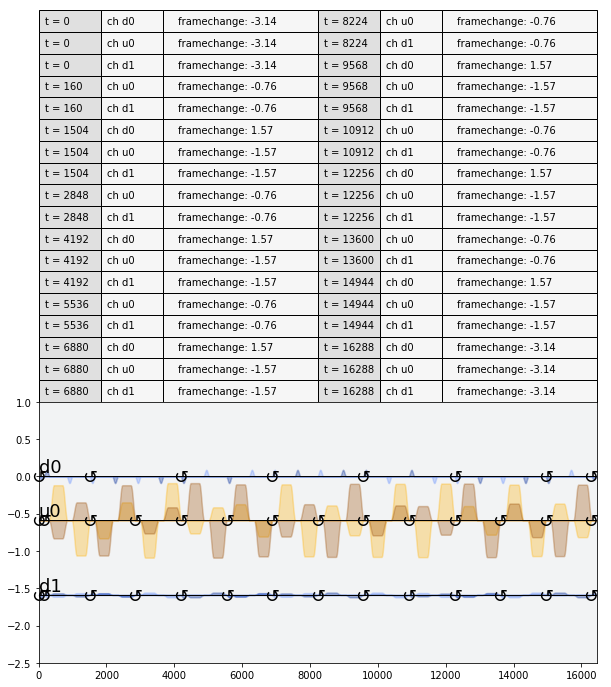

In [10]:
schedules[0].draw(channels=[config.drive(0), config.drive(1), config.control(0)])

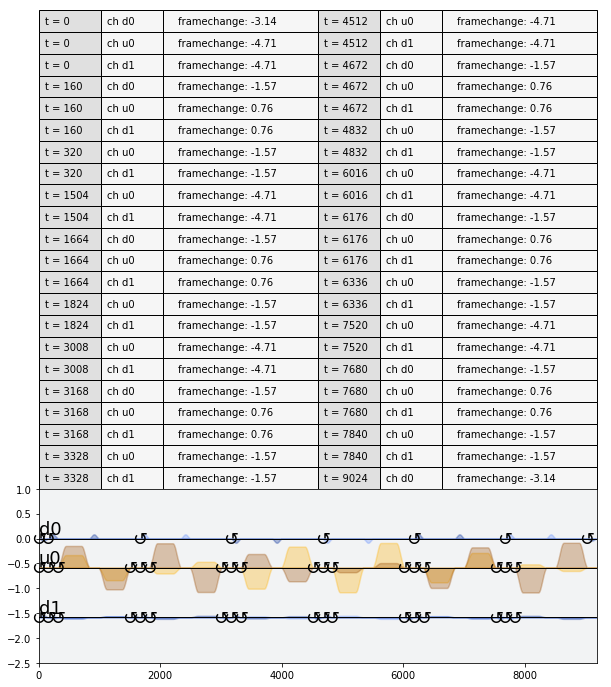

In [11]:
schedules[1].draw(channels=[config.drive(0), config.drive(1), config.control(0)])

In [12]:
shots = 8000
job = q.execute(schedules, backend=backend, shots=shots)
print('job is %s' % job.job_id())

job is 5ddc4a1e3f37b50011607ea2


/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [20]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

# Run a mitigation cal job

In [14]:
import qiskit.ignis.mitigation.measurement as mit
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0,1])
meas_qcs_transpiled = q.transpile(meas_qcs, backend, basis_gates=['x'])
meas_schedules = q.schedule(meas_qcs_transpiled, backend=backend, cmd_def=cmd_def)

In [15]:
job_mit = q.execute(meas_schedules, backend, shots=shots)
print('job_mit is %s' % job_mit.job_id())

job_mit is 5ddc4a34a2825600110caf63


In [24]:
job_mit.status()

<JobStatus.DONE: 'job has successfully run'>

-----
## Analysis

In [25]:
from qiskit.result import marginal_counts

In [26]:
result = job.result()

In [27]:
# mitigate results
result_mit = marginal_counts(job_mit.result(), [0,1])
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels)
readout_fitter.cal_matrix

array([[0.962375, 0.077   , 0.073625, 0.007875],
       [0.025   , 0.909375, 0.005125, 0.070875],
       [0.011375, 0.002   , 0.89775 , 0.089375],
       [0.00125 , 0.011625, 0.0235  , 0.831875]])

In [28]:
standard_counts = marginal_counts(result.get_counts(0), [0,1])
print('before mitigation:')
print(standard_counts)

standard_counts = readout_fitter.filter.apply(standard_counts)
print('\n\n\n after mitigation:')
print(standard_counts)

before mitigation:
{'00': 4063, '01': 432, '10': 3060, '11': 445}



 after mitigation:
{'00': 3939.5499882017934, '01': 314.4759147774877, '10': 3314.9990193520703, '11': 430.97507766864834}


In [29]:
optimized_counts = marginal_counts(result.get_counts(1), [0,1])
print('before mitigation:')
print(optimized_counts)

optimized_counts = readout_fitter.filter.apply(optimized_counts)
print('\n\n\n after mitigation:')
print(optimized_counts)

before mitigation:
{'00': 4899, '01': 261, '10': 2597, '11': 243}



 after mitigation:
{'00': 4864.116157614471, '01': 121.57262894139924, '10': 2810.605907462678, '11': 203.705305981451}


In [30]:
# sanitize data and plot
for key in standard_counts:
    standard_counts[key] = int(standard_counts[key])
for key in optimized_counts:
    optimized_counts[key] = int(optimized_counts[key])

In [31]:
standard_counts

{'00': 3939, '01': 314, '10': 3314, '11': 430}

In [32]:
optimized_counts

{'00': 4864, '01': 121, '10': 2810, '11': 203}

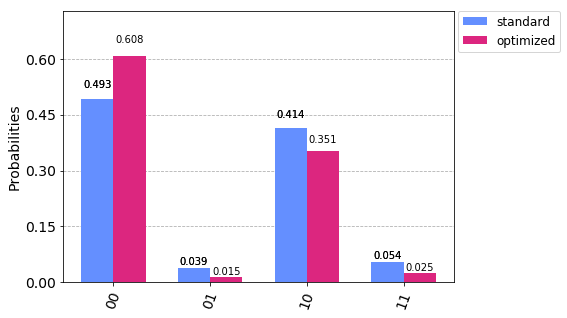

In [34]:
from qiskit.visualization import plot_histogram
plot_histogram([standard_counts, optimized_counts], legend=['standard', 'optimized'])

In [35]:
ideal_counts = {'00': .576492*4000, '10': .423507*4000}  # https://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B%22H%22%2C%22H%22%5D%2C%5B%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%220.75980%22%7D%5D%2C%5B%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%220.75980%22%7D%5D%2C%5B%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%220.75980%22%7D%5D%2C%5B%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%220.75980%22%7D%5D%2C%5B%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%220.75980%22%7D%5D%2C%5B%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%220.75980%22%7D%5D%2C%5B%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F2%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%22H%22%2C%22H%22%5D%5D%7D
# standard_counts =
# optimized_counts = {'00': 3.2117147307346117e-09, '01': 4201.575210406215, '10': 3798.4247895903336, '11': 2.401224165590816e-10}

In [36]:
print(pulse_compiler_helper_fns.kl_divergence(ideal_counts, standard_counts))
print(pulse_compiler_helper_fns.kl_divergence(ideal_counts, optimized_counts))

0.0999105017177394
0.0483001330536135


In [37]:
print(pulse_compiler_helper_fns.cross_entropy(ideal_counts, standard_counts))
print(pulse_compiler_helper_fns.cross_entropy(ideal_counts, optimized_counts))

0.7813093735984175
0.7296990049342917


In [39]:
from qiskit.quantum_info import hellinger_fidelity
print(hellinger_fidelity(ideal_counts, standard_counts))
print(hellinger_fidelity(ideal_counts, optimized_counts))

0.7804729339827983
0.8511686649454064
